In [1]:
!python -V

Python 3.9.23


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

# Set up MLFLOW

In [6]:
import mlflow 

mlflow.set_tracking_uri("sqlite:///mlflow.db")# set tracking url 
mlflow.set_experiment("nyc-taxi-experiment") # create the experiment 

2025/06/25 13:07:02 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/06/25 13:07:02 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlopszoomcamp/week2/mlruns/1', creation_time=1750688460908, experiment_id='1', last_update_time=1750688460908, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

/tmp/ipykernel_2356/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2356/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


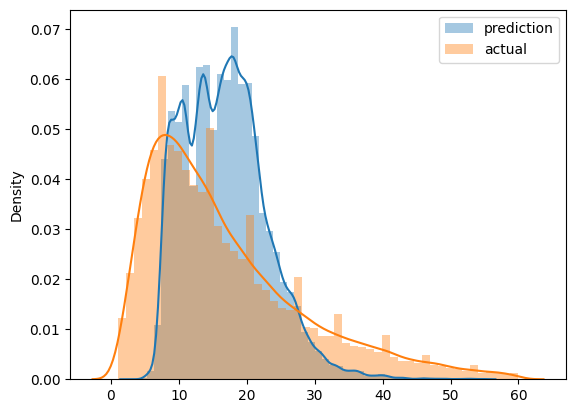

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
# tracking with defining a run 
with mlflow.start_run(): 

    mlflow.set_tag("developer","me") # set tag 

    mlflow.log_param("train-data","2021-01-green") # log parameters 
    mlflow.log_param("validation-data","2021-02-green")



    alpha = 0.01 
    mlflow.log_param("alpha",alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train) # fit data 

    y_pred = lr.predict(X_val) # predict 

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse) # log matrics 

    # saving model as artifact 
    mlflow.log_artifact(local_path="models/lin_reg.bin",artifact_path="models_pickle") # local path and in ml GUI path 



# Hyperparameter tuning with mlflow 

In [20]:
import xgboost as xgb

In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [23]:
def objective(params): # hyperopt objective function 
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost") # every run during tuning is recorded to find best parameters 
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [23]:
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed': 42
# }

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

# Best Model 
You can sort all record by desc rmse to find the pair of best parameters, then train the model using the parameters, save the model and log the training in mlflow. This time, instead of adding tags, we will use auto log 

In [ ]:
params = {
    'learning_rate': 0.1557567395831292,
    'max_depth': 10,
    'min_child_weight': 1.716416307091764,
    'objective': 'reg:linear',
    'reg_alpha': 0.027589494435073993,
    'reg_lambda': 0.05813256739773465,
    'seed': 42
}


mlflow.xgboost.autolog(log_datasets=False) # log online datasets could crash the autolog 
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2025/06/24 02:00:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '82d5ea91b6a54c31aa9f83acd341ac29', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


/home/codespace/anaconda3/envs/week2-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:00:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.99990
[1]	validation-rmse:10.03189
[2]	validation-rmse:9.26994
[3]	validation-rmse:8.67609
[4]	validation-rmse:8.21642
[5]	validation-rmse:7.86089
[6]	validation-rmse:7.59085
[7]	validation-rmse:7.38312
[8]	validation-rmse:7.22599
[9]	validation-rmse:7.10573
[10]	validation-rmse:7.01421
[11]	validation-rmse:6.94278
[12]	validation-rmse:6.88631
[13]	validation-rmse:6.84316
[14]	validation-rmse:6.80932
[15]	validation-rmse:6.78308
[16]	validation-rmse:6.76281
[17]	validation-rmse:6.74500
[18]	validation-rmse:6.73210
[19]	validation-rmse:6.72066
[20]	validation-rmse:6.71122
[21]	validation-rmse:6.70148
[22]	validation-rmse:6.69493
[23]	validation-rmse:6.69017
[24]	validation-rmse:6.68575
[25]	validation-rmse:6.68172
[26]	validation-rmse:6.67870
[27]	validation-rmse:6.67550
[28]	validation-rmse:6.67444
[29]	validation-rmse:6.67192
[30]	validation-rmse:6.67075
[31]	validation-rmse:6.66982
[32]	validation-rmse:6.66859
[33]	validation-rmse:6.66760
[34]	validation-rmse:6

In [26]:
# second way to save model 
with mlflow.start_run(): 

    # include the preprocessing steps 
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    params = {
        'learning_rate': 0.1557567395831292,
        'max_depth': 10,
        'min_child_weight': 1.716416307091764,
        'objective': 'reg:linear',
        'reg_alpha': 0.027589494435073993,
        'reg_lambda': 0.05813256739773465,
        'seed': 42
    }


    mlflow.log_params(params)

    booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val,y_pred)
    mlflow.log_metric("rmse",rmse)

    with open("models/preprocessor.b","wb") as f_out: 
        pickle.dump(dv, f_out) # save the dv, which is the vectorisor 

    mlflow.log_artifact("models/preprocessor.b",artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")

/home/codespace/anaconda3/envs/week2-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:31:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.99990
[1]	validation-rmse:10.03189
[2]	validation-rmse:9.26994
[3]	validation-rmse:8.67609
[4]	validation-rmse:8.21642
[5]	validation-rmse:7.86089
[6]	validation-rmse:7.59085
[7]	validation-rmse:7.38312
[8]	validation-rmse:7.22599
[9]	validation-rmse:7.10573
[10]	validation-rmse:7.01421
[11]	validation-rmse:6.94278
[12]	validation-rmse:6.88631
[13]	validation-rmse:6.84316
[14]	validation-rmse:6.80932
[15]	validation-rmse:6.78308
[16]	validation-rmse:6.76281
[17]	validation-rmse:6.74500
[18]	validation-rmse:6.73210
[19]	validation-rmse:6.72066
[20]	validation-rmse:6.71122
[21]	validation-rmse:6.70148
[22]	validation-rmse:6.69493
[23]	validation-rmse:6.69017
[24]	validation-rmse:6.68575
[25]	validation-rmse:6.68172
[26]	validation-rmse:6.67870
[27]	validation-rmse:6.67550
[28]	validation-rmse:6.67444
[29]	validation-rmse:6.67192
[30]	validation-rmse:6.67075
[31]	validation-rmse:6.66982
[32]	validation-rmse:6.66859
[33]	validation-rmse:6.66760
[34]	validation-rmse:6

2025/06/25 13:32:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/codespace/anaconda3/envs/week2-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:32:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/06/25 13:32:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# 2 ways to log model: 

1. log model as artifact 
2. use log_model method to log the model 

In [ ]:
# used logged model for prediction 
logged_model = 'runs:/adbb0768ce44421fbfdcc58684f578aa/models_mlflow'

loaded_model = mlflow.pyfunc.load_model(logged_model)


In [28]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: /workspaces/mlopszoomcamp/week2/mlruns/1/models/m-fc3593cc0a7846e38a8f59e2ff68c450/artifacts
  flavor: mlflow.xgboost
  run_id: adbb0768ce44421fbfdcc58684f578aa

In [ ]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [ ]:
xgboost_model # model becomes an object 

In [ ]:
# make prediction
y_pred = xgboost_model.predict(valid) 

# this is not applying the preprocessofr we saved. If we want to use that, need to use pickle to load the saved dv and still include the code for transformation 

# however it is possible to save both together in same artifact and apply f

In [32]:
y_pred[:10]

array([15.184608,  7.193801, 16.93405 , 24.365328,  9.278277, 17.098824,
       12.975654,  8.915227,  8.916344, 17.324223], dtype=float32)